<a href="https://colab.research.google.com/github/MaxVortman/IDEA-code-clones/blob/master/colab/code_clones_bag_of_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My\ Drive/code-clones

/content/gdrive/My Drive/code-clones


In [3]:
!ls

all_tests.txt  data	__pycache__  train.txt	 xmlextractor.py
csv	       log.txt	test.txt     v0.2.0.zip


In [0]:
import xmlextractor
import metrics
import os
import pandas as pd
import numpy as np

In [0]:
duplicates = xmlextractor.parseXml("data/lwjgl-master/duplicates.xml", "data/lwjgl-master")
duplicates.extend(xmlextractor.parseXml("data/lwjgl3-master/duplicates.xml", "data/lwjgl3-master"))
duplicates.extend(xmlextractor.parseXml("data/spring-framework-master/duplicates_marked.xml", "data/spring-framework-master"))
duplicates.extend(xmlextractor.parseXml("data/jenkins-master/duplicates_marked.xml", "data/jenkins-master"))
duplicates.extend(xmlextractor.parseXml("data/RxJava-2.x/duplicates_marked.xml", "data/RxJava-2.x"))

In [7]:
print(len(duplicates))
print(len(list(filter(lambda d: d.exp == 0, duplicates))))
print(len(list(filter(lambda d: d.exp == 1, duplicates))))

19990
14560
5430


## TF-IDF

In [0]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

def resample(X, y):
  rus = RandomUnderSampler(random_state=23)
  return rus.fit_resample(X, y)

In [0]:
dup = []
for duplicate in duplicates:
    text = '\n\n'.join(duplicate.fragments)
    dup.append({'text': text, 'exp': duplicate.exp})

In [0]:
df_tfidf = pd.DataFrame(dup)
X = np.array(df_tfidf['text'])
y = np.array(df_tfidf['exp'])
X_resampled, y_resampled = resample(X.reshape(-1, 1), y.reshape(-1, 1))
X_resampled = X_resampled.reshape(1, -1)[0]
y_resampled = y_resampled.reshape(1, -1)[0]

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(ngram_range=(1,1))
X_count = count_vec.fit_transform(X_resampled)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_resampled, random_state=23)

In [12]:
%cd /
!git clone https://github.com/hyperopt/hyperopt-sklearn
%cd hyperopt-sklearn
!pip install -e .

/
Cloning into 'hyperopt-sklearn'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1171 (delta 1), reused 4 (delta 0), pack-reused 1164
Receiving objects: 100% (1171/1171), 2.01 MiB | 31.66 MiB/s, done.
Resolving deltas: 100% (706/706), done.
/hyperopt-sklearn
Obtaining file:///hyperopt-sklearn
  Found existing installation: hpsklearn 0.0.3
    Can't uninstall 'hpsklearn'. No files were found to uninstall.
  Running setup.py develop for hpsklearn


In [13]:
from hpsklearn import HyperoptEstimator, any_sparse_classifier, tfidf
from hyperopt import tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [0]:
def custom_loss(y_target, y_prediction):
  k_fn = 1
  k_fp = 10
  n = len(y_target)
  (fnr, fpr) = metrics.calc_fnr_fpr(y_target, y_prediction)
  return k_fn * fnr + k_fp * fpr

In [15]:
estim = HyperoptEstimator(classifier=any_sparse_classifier('clf'),
                          preprocessing=[],
                          algo=tpe.suggest,
                          trial_timeout=300,
                          loss_fn=custom_loss,
                          seed=23)
estim.fit(X_train, y_train)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



100%|██████████| 1/1 [00:00<00:00, 16.18it/s, best loss: 1.092694904849601]


In [16]:
y_pred = estim.predict(X_test)
metrics.print_fnr_fpr(y_test, y_pred)

(0.19373848987108655, 0.09907918968692449)

In [17]:
estim.best_model()

{'ex_preprocs': (),
 'learner': SGDClassifier(alpha=0.06118428364662971, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0003970052556398526,
        fit_intercept=True, l1_ratio=0.5022724095962902,
        learning_rate='constant', loss='log', max_iter=158684350.0,
        n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='l2',
        power_t=0.907051629874976, random_state=0, shuffle=True,
        tol=0.006308140398304822, validation_fraction=0.1, verbose=False,
        warm_start=False),
 'preprocs': ()}

In [0]:
y_prob = [y[1] for y in estim.best_model()['learner'].predict_proba(X_test)]

In [19]:
metrics.print_roc_auc(y_test, y_prob)


roc auc: 
0.8001453188546463


## Косинусное расстояние между дубликатами.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

distance = []

for i in duplicates:
  try:
    vect = CountVectorizer(ngram_range=(1,1))
    vectors = vect.fit_transform(i.fragments)
    distance.append({'exp': i.exp, 'distance': np.min(cosine_similarity(vectors))})
  except: 
    continue

In [0]:
df = pd.DataFrame(distance)
df.head()

,distance,exp
0,1.0000,0
1,1.0000,0
2,1.0000,0
3,1.0000,0
4,0.9667,0


In [0]:
# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

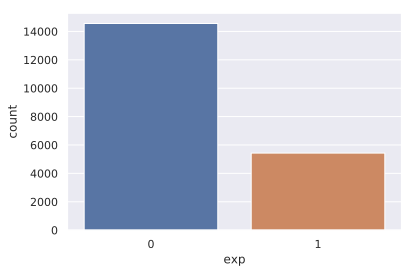

In [0]:
sns.countplot(x='exp', data=df);

In [0]:
df.to_csv('csv/bagofwords_cos.csv', index=False)

## Мешок слов.

In [0]:
dupBoW = []
for duplicate in duplicates:
    text = '\n\n'.join(duplicate.fragments)
    dupBoW.append({'text': text, 'exp': duplicate.exp})

In [0]:
df = pd.DataFrame(dupBoW)
df.head()

,exp,text
0,0,/**\n * A hash map using primitive ints as key...
1,0,\tprivate static ByteBuffer readImage(final Bu...
2,0,\t\tSpriteRendererTF() {\n\t\t\tSystem.out.pri...
3,0,\t/**\n\t * Processes keyboard input\n\t */\n\...
4,0,"if (!VertLeq(o1, d1)) {\n G..."


In [0]:
df.describe()

,exp
count,19990.000000
mean,0.271636
std,0.444814
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [0]:
vect = CountVectorizer(ngram_range=(1,1))
bagOfWords = vect.fit_transform(df['text'])

In [0]:
from scipy import sparse

In [0]:
y = sparse.coo_matrix(df['exp'])

In [0]:
sparse.save_npz("csv/bagofwords_vectors_X.npz", bagOfWords)
sparse.save_npz("csv/bagofwords_vectors_y.npz", y)

## Анализ предсказаний.

In [0]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

In [0]:
def resample(X, y):
  rus = RandomUnderSampler(random_state=23)
  return rus.fit_resample(X, y)

In [0]:
y = df['exp']
X = df.drop('exp', 1)
X_resampled, y_resampled = resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=23)
clf = LogisticRegression(random_state=23)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))

array([ 21,  22,  23,  28,  38,  45,  82,  85,  87, 104, 114, 136, 146,
       161, 176, 203, 206, 208, 210, 212, 221, 245, 261, 270, 278, 292,
       319, 328, 343, 355, 364, 367, 372, 392, 407, 409, 415, 416, 421,
       426, 437, 443, 468, 533, 536])

In [0]:
print(dupBoW[21]['text'])

		if (dest == null)
			dest = new Matrix3f();

		dest.m00 = left.m00 - right.m00;
		dest.m01 = left.m01 - right.m01;
		dest.m02 = left.m02 - right.m02;
		dest.m10 = left.m10 - right.m10;
		dest.m11 = left.m11 - right.m11;
		dest.m12 = left.m12 - right.m12;
		dest.m20 = left.m20 - right.m20;
		dest.m21 = left.m21 - right.m21;
		dest.m22 = left.m22 - right.m22;

		if (dest == null)
			dest = new Matrix4f();

		dest.m00 = left.m00 - right.m00;
		dest.m01 = left.m01 - right.m01;
		dest.m02 = left.m02 - right.m02;
		dest.m03 = left.m03 - right.m03;
		dest.m10 = left.m10 - right.m10;
		dest.m11 = left.m11 - right.m11;
		dest.m12 = left.m12 - right.m12;
		dest.m13 = left.m13 - right.m13;
		dest.m20 = left.m20 - right.m20;


In [0]:
np.intersect1d(np.where(y_pred == 0), np.where(y_test == 1))

array([ 94, 107, 109, 119, 190, 223, 231, 252, 289, 294, 342, 345, 347,
       356, 362, 376, 395, 454, 489, 528, 534])

In [0]:
print(dupBoW[534]['text'])

					glRectf(-50.0f, -50.0f, 50.0f, 50.0f);
					glPopMatrix();
					swapBuffers();
					repaint();

					glRectf(-50.0f, -50.0f, 50.0f, 50.0f);
					glPopMatrix();
					swapBuffers();
					repaint();


In [0]:
np.intersect1d(np.where(y_pred == 1), np.where(y_test == 1))

array([  2,   4,   5,   8,   9,  10,  13,  17,  19,  20,  24,  30,  33,
        39,  40,  41,  43,  44,  47,  48,  50,  52,  54,  57,  58,  63,
        64,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,
        83,  88,  92,  97,  98, 101, 103, 105, 110, 112, 115, 118, 120,
       125, 128, 129, 131, 132, 134, 135, 137, 138, 139, 141, 142, 145,
       147, 149, 153, 154, 157, 160, 164, 166, 167, 168, 170, 174, 175,
       177, 179, 180, 182, 183, 184, 185, 186, 191, 192, 195, 196, 197,
       198, 200, 201, 202, 204, 205, 207, 213, 214, 217, 222, 227, 229,
       230, 234, 237, 241, 242, 244, 246, 248, 249, 254, 257, 258, 259,
       260, 262, 263, 265, 267, 268, 273, 276, 281, 284, 285, 286, 290,
       291, 293, 298, 300, 301, 304, 305, 306, 308, 309, 311, 313, 314,
       316, 317, 321, 323, 324, 326, 327, 329, 331, 332, 333, 337, 340,
       346, 348, 349, 350, 352, 357, 360, 365, 369, 370, 373, 374, 378,
       380, 383, 384, 386, 387, 388, 389, 390, 391, 393, 394, 39

In [0]:
print(dupBoW[517]['text'])

			data.view = i;

			data.foo = i;
			data.pointer = i * 1000;

			data.view = i;

			data.foo = i;
			data.bar = i * 2;
